# Clustering occurrenceid in iDigBio data

Spark has an entire machine learning library for clustering, classification, inferance, and modeling on large data sets. We'll use some very simple clustering to explore what kinds of identifiers people use in the occurrenceid field in iDigBio.

If you would like to follow the code, please review 01_iDigBio_Specimens_Collected_Over_Time.ipynb and 02_iDigBio_and_GBIF_Specimens_By_Continent_Over_Time.ipynb first as the ideas presented there will be skipped over in this notebook.

If you are just interested in the final results, feel free to skip to the end.

In [20]:
import re

from pyspark.sql.functions import col, length, udf
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [21]:
df = sqlContext.read.load("/guoda/data/idigbio-20190426T013311-100k.parquet")

## Features

When clustering, the algorithm used needs to know what aspects of the data to consider when trying to decide how similar two things are. These aspects are refered to as "features". In the algorithm we are going to use, k-means, features must be numeric and the distance between the numbers must be related to how similar the data are to each other. That is, for three data points A, B, and C with feature values 0, 1, and 10, then points A and C are 10 times less related than points A and B. 

We need to pick these features in advance according to our intuition and understanding of the data. There are methods of finding the best features and neural networks actually make up their own features with no input at all.

For this notebook we are going to use three features:

1. The total lenght of the occurrenceid
2. The number of characters that are valid for a hexadecimal number (0-1 and A-F)
3. The number of special characters

We have to calculate these features from the raw data ourselves. Fortunately they're all simple calculations. The Spark machine learning libraries need to have them represented as a dataframe with a column named "features" that contains a vector with the values of each feature for the record.

This is where we will again use a user defined function to do this.

In [22]:
# compile regular expressions in advance for a bit of speed
hex_chars = re.compile(r'[0-9a-fA-F]')
special_chars = re.compile(r'[\:\\\-_ ]')

def make_features(occurrenceid):
    return Vectors.dense(
        len(occurrenceid),
        len(re.findall(hex_chars, occurrenceid)),
        len(re.findall(special_chars, occurrenceid))
    )

make_features_udf = udf(make_features, VectorUDT())

In [23]:
features = (df
            .select(col("occurrenceid"),
                    make_features_udf(col("occurrenceid")).alias("features"))
            .persist()
            )

In [24]:
features.head(10)

[Row(occurrenceid='urn:uuid:856b9c56-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:83a78218-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:841d3b34-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:871242ee-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:863e9d4a-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:cb6a253a-003f-11e3-8e88-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:82cc4888-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:84be62b6-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:8517336e-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='

The `features` data frame now has the original occurrenceid along with a vector of features for each one. You can count up some characters in the output above to check it.

Notice that persisted() this data frame. One of the great advantages of  Spark over other distributed processing engines is that it can preserve data frames like this in memory as they are repeatedly used and accessed which machine learning does a lot.

## k-means and selecting k

You can read more about [k-means works here](https://en.wikipedia.org/wiki/K-means_clustering). In a nutshell, it tries to minimize the SSE distances from a fixed number of cluster centroids in the feature space.

Huh?

It assumes there are a fixed number of cluster centers and it picks a random location as a guess for where each one is. Then it calculates the sum of the squares of all the distances from the data to those points. Then it moves the centers a bit and sees if the distances go down.

One of the drawbacks here is that you need to give the algorithm a number of clusters to try to optimize to. This makes sense because if you didn't the optimal solution would be for each data point to be its own cluster.

Fortunately picking a k for a comparatively small data set like these can be done by simply trying a range of them and graphing k vs the sum of the squared errors. The point at which there is an elbow in the graph is probably a good k value to use.

We'll just take a guess and let k vary from 5 to 20.

In [25]:
# parallel arrays for the win
ks = []
models = []
centers = []
costs = []

for i in range(5, 21):
    kmeans = KMeans(k=i, seed=1)
    model = kmeans.fit(features)
    ks.append(i)
    models.append(model)
    centers.append(model.clusterCenters())
    costs.append(model.computeCost(features))

For the 100k parquet and a small allocation, that takes about 20-30 seconds. For the entire 100 million row iDigBio data frame and using the whole cluster it takes about 15 minutes.

We now have four arrays that are all lined up. Let's look at the costs first. These are the total SSE values added up for all the points in the data set.

In [26]:
print(costs)

[478134.4818440371, 396891.6318830741, 212132.97895124086, 180022.46220084443, 146277.97113583615, 125794.83001545875, 124069.20752218677, 98241.41719851004, 96300.72588614676, 96300.72588614676, 64801.92774630434, 58450.79080184875, 56725.17823214374, 62447.164582512865, 66363.23671686856, 54455.531069584955]


Now let's plot k vs the total costs.

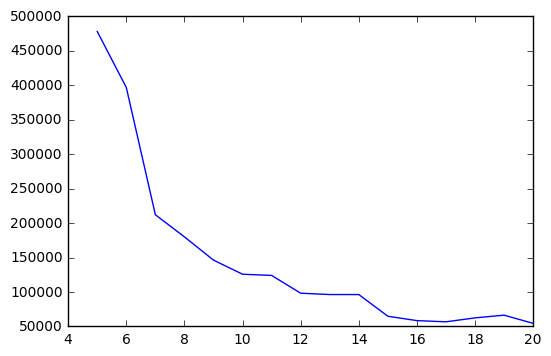

In [27]:
plt.plot(ks, costs)

Returns in reducint the sum of the errors certainly have fallen off by k=15 so we'll pick that as our final k.

In [28]:
final_k = 15

# Looking at the model output

In [29]:
centers_df = pd.DataFrame(centers[ks.index(final_k)])
centers_df

,0,1,2
0,50.935868,16.926079,1.031349
1,24.399227,9.272392,4.005010
2,45.008303,33.008303,6.000000
3,36.000000,32.000000,4.000000
4,14.997839,8.996111,1.003889
5,17.000000,10.274566,1.000000
6,31.204960,16.142232,4.000000
7,30.180260,10.468423,4.999365
8,22.228219,8.916049,4.000000
9,58.841398,21.053763,5.451613


Notice that one of the clusters has a total length of 36, number of hex characters of 32, and special characters of 4. This exactly matches the format of a uuid when we know many providers use so it looks like our model found some useful information.

## Displaying results

We happen to have three features so we can plot our cluster centers in 3D. To make the display a little nicer, let's make the sizes of the points relative to the number of occurrenceids that are in the cluster.

One of the things we saved from the k-means clustering process is the actual model itself. This is an object that contains the results of all the calculations done and it includes a dataframe of the predictions that the model made for each occurenceid.

Let's take a look:

In [30]:
final_model = models[ks.index(final_k)]

final_model.summary.predictions.head(10)

[Row(occurrenceid='urn:uuid:856b9c56-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:83a78218-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:841d3b34-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:871242ee-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:863e9d4a-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:cb6a253a-003f-11e3-8e88-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:82cc4888-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrenceid='urn:uuid:84be62b6-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=2),
 Row(occurrencei

We can summarize these predictions by the cluster number and convert it to Pandas for plotting. We will also scale the counts to a range that makes sense for the range of values that our plotting function expects:

In [31]:
sizes = (final_model.summary.predictions
         .groupBy(col("prediction"))
         .count()
         .orderBy(col("prediction"))
         .toPandas()
         )
max_size = 1000
sizes["scaled"] = (sizes["count"] / sizes["count"].max() ) * max_size

In [32]:
sizes.head(10)

,prediction,count,scaled
0,0,23701,655.974094
1,1,11377,314.881957
2,2,36131,1000.000000
3,3,5134,142.094047
4,4,2314,64.044726
5,5,1038,28.728792
6,6,1371,37.945255
7,7,3151,87.210429
8,8,5670,156.928953
9,9,372,10.295868


Finally we can graph our cluster centers. This graph is a little unusual in that we can actually label the axes. Often times clustering uses many features and grphical displays will use virtually calculated axes from principle component analysis or some other dimensionallity reduction method.

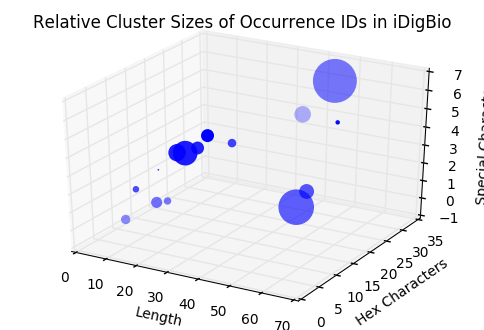

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=centers_df[0], ys=centers_df[1], zs=centers_df[2],
           s=sizes["scaled"], edgecolor='')

plt.title("Relative Cluster Sizes of Occurrence IDs in iDigBio")
plt.xlabel("Length")
plt.ylabel("Hex Characters")
ax.set_zlabel("Special Characters")

We can also look at the actual values in the predictions data frame to get some examples of the kinds of identifiers that were clustered together.

In [34]:
for i in [0, 1, 2, 3]:
    print("Cluster {0}".format(i))
    print(final_model.summary.predictions
     .filter(col("prediction") == i)
     .select(col("occurrenceid"))
     .limit(5)
     .toPandas()
     )

Cluster 0
                                        occurrenceid
0   http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey241
1  http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey6475
2  http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey9659
3  http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey9618
4  http://coldb.mnhn.fr/catalognumber/mnhn/ey/ey8863
Cluster 1
                occurrenceid
0  urn:catalog:trom:v:961366
1   urn:catalog:cas:ds:84042
2   urn:catalog:cas:ds:68327
3   urn:catalog:cas:ds:40983
4   urn:catalog:cas:ds:45273
Cluster 2
                                    occurrenceid
0  urn:uuid:856b9c56-d8e1-11e2-99a2-0026552be7ea
1  urn:uuid:83a78218-d8e1-11e2-99a2-0026552be7ea
2  urn:uuid:841d3b34-d8e1-11e2-99a2-0026552be7ea
3  urn:uuid:871242ee-d8e1-11e2-99a2-0026552be7ea
4  urn:uuid:863e9d4a-d8e1-11e2-99a2-0026552be7ea
Cluster 3
                           occurrenceid
0  18ed8d3e-c9c3-4224-853b-9a4d055ced87
1  9e7021b7-a4e4-4d27-8f88-0b4dd3b7d880
2  756a4299-96e3-4bb7-9160-5b35b49fcde8
3  93f4f870-7d